# Import libs

In [5]:
import pandas as pd
import numpy as np
import scipy
from utils.functions import min_max_normalization, plot_column_histogram_and_distribution, confusion_matrix
from sklearn.model_selection import train_test_split
from models.naive_bayes_classifier.naive_bayes_classifier import naive_bayes_classifier

# Import Column dataset and doing normalization

In [6]:
columns_name = [
    'pelvic_incidence', 
    'pelvic_tilt', 
    'lumbar_lordosis_angle', 
    'sacral_slope', 
    'pelvic_radius', 
    'degree_spondylolisthesis',
    'class'
]
Xy = pd.read_csv('./datasets/vertebral_column_3C.dat', header=0, names=columns_name, sep=' ', engine='python')

X = min_max_normalization(Xy.drop(Xy.columns[-1:], axis=1))
y = Xy[Xy.columns[-1]]

# Plotting dataset columns distributions

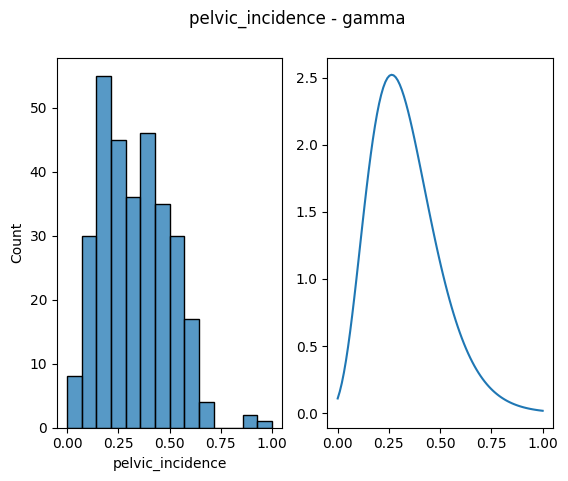

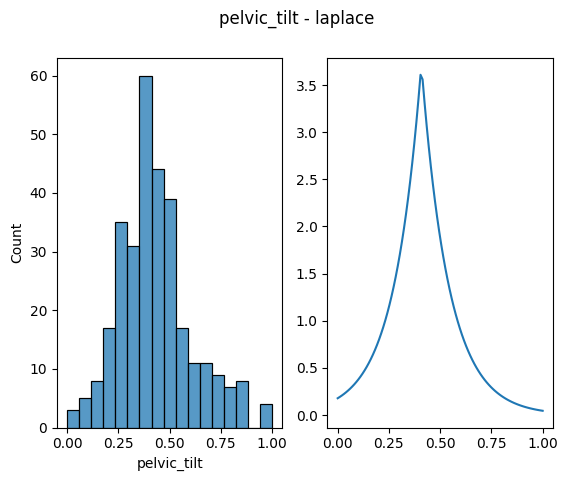

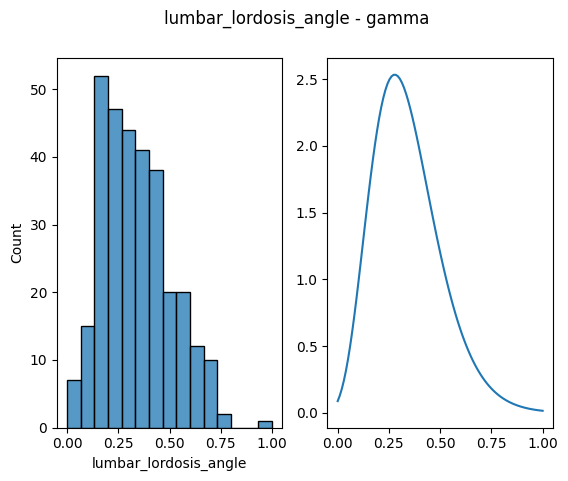

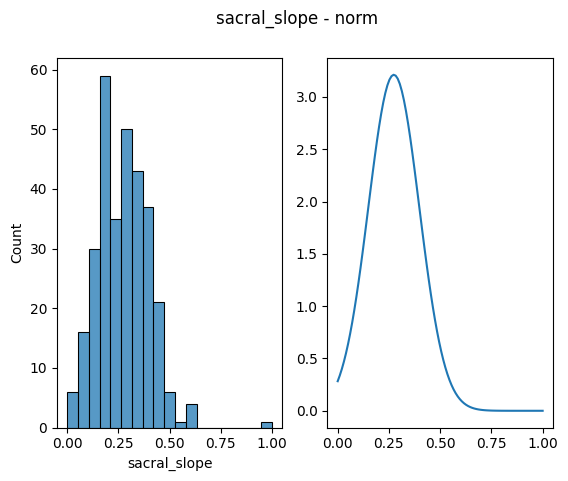

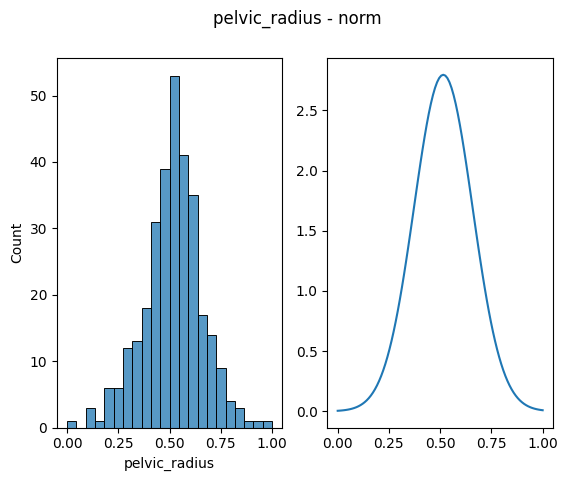

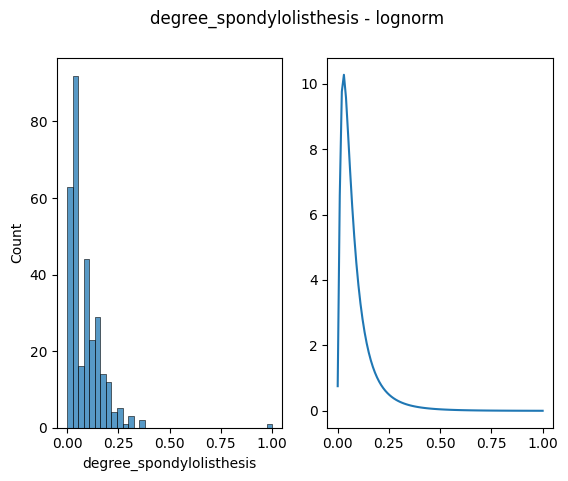

In [7]:
distributions = ['gamma', 'laplace', 'gamma', 'norm', 'norm', 'lognorm']

for feature_name, distribution in zip(X.columns, distributions):
    plot_column_histogram_and_distribution(X[feature_name], feature_name, distribution)

# New Naive Bayes implementation

In [12]:
class naive_bayes_classifier:
    def __init__(self, features_distribution=[]):
        # will save the priori for each class
        self.__priori = []  # [<priori_class_1>, <priori_class_2>, ...]

        # will save the distribution type for each column
        self.__features_distribution = features_distribution

        #                                                                                   attrb 1      attrb 2
        # will save the distribuition instance of each attribute for each class: class 1 [(mean, std), (mean, std), ...]
        #                                                                        class 2 [    ...    ,     ...    , ...]
        self.__features_distribution_instances = pd.DataFrame([[]])

    def fit(self, X, y):
        if len(self.__features_distribution) == 0:
            self.__features_distribution = ['norm' for _ in range(len(X.columns))]
        elif len(self.__features_distribution) != len(X.columns):
            raise Exception('Features distributions size is different X columns size')

        classes = pd.Series(y.unique())
        values = [[() for _ in range(len(X.columns))] for _ in range(len(classes))]
        self.__features_distribution_instances = pd.DataFrame(values, columns=X.columns, index=classes)

        for cls in self.__features_distribution_instances.index.values:
            i_cls_samples = X.index[np.where(y == cls)] # this take the index returned for np and take the pd (X) index
            Xc = X.loc[i_cls_samples]
            self.__priori.append(len(Xc) / len(X))  # insert priori for each group of samples separated per class

            for feature, feat_distribution in zip(X.columns, self.__features_distribution):
                distribution = getattr(scipy.stats, feat_distribution)
                distr_params = distribution.fit(Xc[feature])
                self.__features_distribution_instances.loc[cls, feature] = distr_params
    
    def predict(self, x):
        if len(x) != len(self.__features_distribution_instances.columns):
            raise Exception('Sample invalid')

        posteriors = [] # [[<posteriori>, <class>], ...]

        for i_cls, cls in enumerate(self.__features_distribution_instances.index.values):
            likelihood = 0
            for i_feature, feature in enumerate(self.__features_distribution_instances.columns):
                distribution = getattr(scipy.stats, self.__features_distribution[i_feature])
                distr_params = self.__features_distribution_instances.loc[cls, feature]
                new_distribution = distribution(*distr_params)
                likelihood = likelihood + new_distribution.pdf(x[i_feature])

            posteriors.append([
                likelihood * self.__priori[i_cls], 
                cls
            ])

        greater_posteriori_class = sorted(
            posteriors,
            key=lambda posteriors: posteriors[0] # sorted by posteriori
        )[-1][1]

        return greater_posteriori_class

    def score(self, X_test, y_test):
        hits = 0

        for sample, predict in zip(X_test.values, y_test.values):
            if self.predict(sample) == predict:
                hits += 1

        return hits/y_test.size

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

nb_model = naive_bayes_classifier(distributions)
nb_model.fit(X_train, y_train)

print('Score:', nb_model.score(X_test, y_test))

nb_y_pred = [nb_model.predict(x) for x in X_test.values]
confusion_matrix(y_test, nb_y_pred)

Score: 0.8387096774193549


,SL,NO,DH
SL,33,1,0
NO,0,19,0
DH,1,8,0
